In [8]:
import math
import numpy as np
import pandas as pd
import torch
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

from src import config

In [3]:
from src.common.logger import create_logger, get_logger
from src.tvp import init_model, train, predict
from src.model.model_util import load_checkpoint, plot_first_kernels

In [3]:
create_logger('./log/brain.log')

In [4]:
get_logger().info('Start Notebook')

[INFO]2019-11-01 15:41:03,590:main:Start Notebook


## use db

In [5]:
from src.db.mstory import ModelDB, GradPlot

In [11]:
db.table_history().head(10)

,time,exid,epoch,iter,mode,batch_size,lr,loss,metrics
0,2019-11-13 15:01:49.378704,1,1,0,train,64,0.00005,0.676600,0.676600
1,2019-11-13 15:02:55.936054,2,1,0,train,64,0.00005,0.774493,0.774493
2,2019-11-13 15:03:06.501174,2,1,20,train,64,0.00005,0.329362,0.329362
3,2019-11-13 15:03:17.165773,2,1,40,train,64,0.00005,0.269304,0.269304
4,2019-11-13 15:03:27.873616,2,1,60,train,64,0.00005,0.247847,0.247847
5,2019-11-13 15:03:38.640885,2,1,80,train,64,0.00005,0.234178,0.234178
6,2019-11-13 15:03:49.516247,2,1,100,train,64,0.00005,0.222039,0.222039
7,2019-11-13 15:04:21.710904,3,1,0,train,64,0.00005,0.730180,0.730180
8,2019-11-13 15:04:32.543694,3,1,20,train,64,0.00005,0.304276,0.304276
9,2019-11-13 15:04:43.475694,3,1,40,train,64,0.00005,0.268165,0.268165


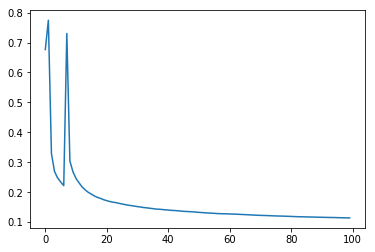

In [17]:
df = db.table_history().head(100)
plt.plot(df['loss'])

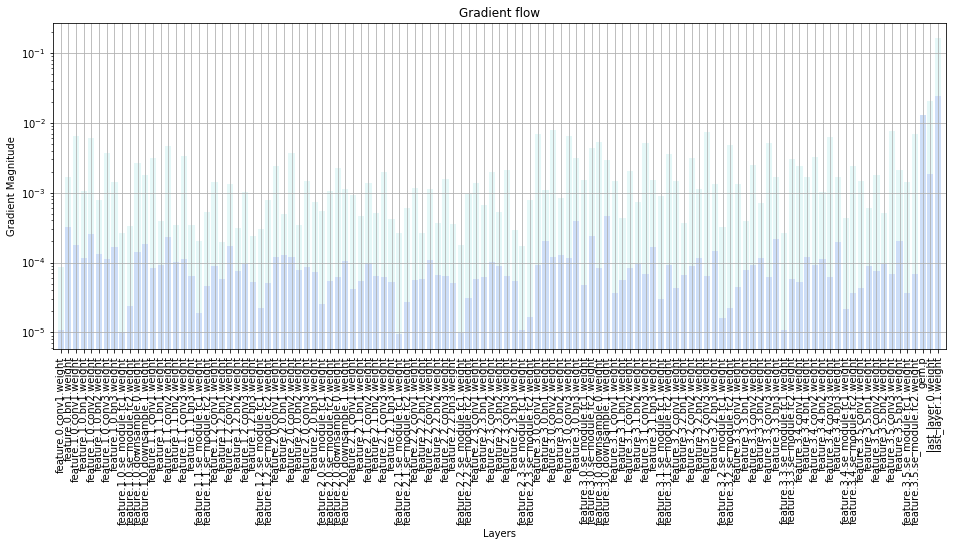

In [15]:
GradPlot.plot_grad(db.get_grad(3, 1, 0))

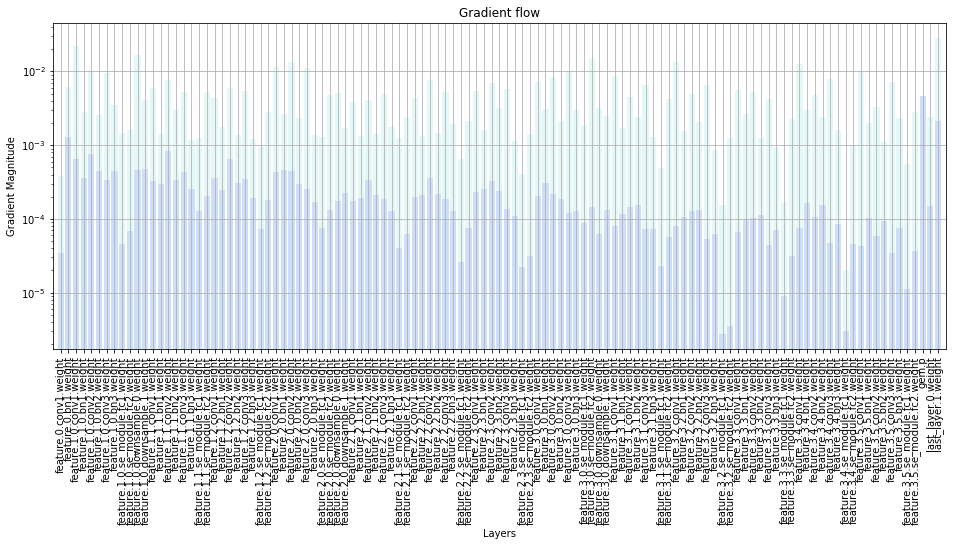

In [14]:
GradPlot.plot_grad(db.get_grad(3, 1, 2600))

## check data

In [5]:
import albumentations as A
import albumentations.pytorch as ATorch
from src.dataset import NormalizePerImage, BrainDataset

trnsfms = A.Compose([
    # A.Resize(*config.IMG_SIZE),
    # A.CLAHE(p=1),
    # A.Rotate(limit=10, p=1),
    # A.RandomSizedCrop((IMG_SIZE[0]-32, IMG_SIZE[0]-10), *INPUT_SIZE),
    # A.RandomCrop(*config.INPUT_SIZE),
    # A.HueSaturationValue(val_shift_limit=20, p=0.5),
    # A.HorizontalFlip(p=0.5),
    # A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
    # A.GaussianBlur(blur_limit=7, p=0.5),
    #     NormalizePerImage(),
    # A.Normalize(
    # mean=[0.485, 0.456, 0.406],
    # std=[0.229, 0.224, 0.225],
    # ),
    #     ATorch.transforms.ToTensor()
], p=1)

In [6]:
df_trn = pd.read_csv(config.TRAIN_PATH)

# visualization train set
print(df_trn.head())

train_dataset = BrainDataset(
    df_trn, config.TRAIN_IMG_PATH, trnsfms, mode='train')

[INFO]2019-11-01 14:11:31,163:main:num of selected_images: 100000


          Image  any  epidural  intraparenchymal  intraventricular  \
0  ID_000039fa0    0         0                 0                 0   
1  ID_00008ce3c    0         0                 0                 0   
2  ID_0000950d7    0         0                 0                 0   
3  ID_0000aee4b    0         0                 0                 0   
4  ID_0000f1657    0         0                 0                 0   

   subarachnoid  subdural   patient_id  
0             0         0  ID_eeaf99e7  
1             0         0  ID_ce8a3cd2  
2             0         0  ID_d278c67b  
3             0         0  ID_ce5f0b6c  
4             0         0  ID_df70c823  


tensor([0, 0, 0, 0, 0, 0])


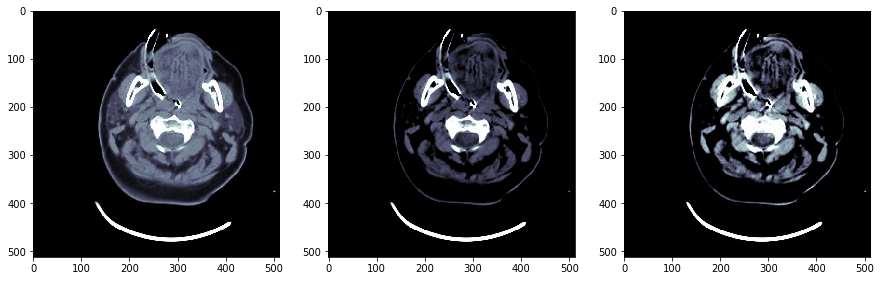

In [7]:
img, label = train_dataset[4]
print(label)
fig, axs = plt.subplots(1, 3, figsize=(15,10))
axs[0].imshow(img[:,:,0], cmap='bone')
axs[1].imshow(img[:,:,1], cmap='bone')
axs[2].imshow(img[:,:,2], cmap='bone')

In [46]:
print(img[300, 300, 0])
print(img[300, 300, 1])
print(img[300, 300, 2])

232
232
232


In [45]:
config.TRAIN_IMG_PATH

'./data/data2_512/stage_1_train_images'

## model visualization

In [ ]:
'''Model Visualization'''
"""

def normalize_channels(img):
    _min, _max = img.min(axis=(0, 1)), img.std(axis=(0, 1))
    img = (img - _min) / (_max - _min)
    return img


def plot_first_kernels(weight):
    ''' plot first filters of a model '''
    with torch.no_grad():
        filters = weight.detach().cpu().float().numpy(
        ).transpose([0, 2, 3, 1])  # channels last
        filters = normalize_channels(filters)
        filters /= filters.max()
    n = filters.shape[0]
    cols = math.ceil(math.sqrt(n))
    rows = math.ceil(n / cols)

    fig, axs = plt.subplots(rows, cols)
    for c in range(cols):
        for r in range(rows):
            idx = r + c * rows
            if idx < n:
                axs[r, c].imshow(filters[idx])
            axs[r, c].set_axis_off()


def plot_norms(named_parameters, figsize=None):
    ''' plot l2 norm distribution for each layer of the given named parameters. e.g. model.named_parameters() '''
    from matplotlib import cm
    p = [0, 25, 50, 75, 100]
    with torch.no_grad():
        norms, names = [], []
        for name, param in named_parameters:
            param_flat = param.view(param.shape[0], -1)
            norms.append(np.percentile(torch.norm(
                param_flat, p=2, dim=1).cpu().numpy(), p))
            names.append(name)

    n = len(norms)
    inv_p = np.arange(len(p) - 1, -1, -1)
    norms = np.array(norms)
    if figsize is None:
        figsize = (np.min([16, n]), 6)
    plt.figure(figsize=figsize)
    plt.yscale('log')
    for i, c in zip(inv_p, cm.get_cmap('inferno')(0.1 + inv_p / len(p))):
        plt.bar(np.arange(n), norms[:, i], lw=1, color=c)
    plt.xticks(range(n), names, rotation="vertical")
    plt.xlabel("layers")
    plt.ylabel("norm distribution")
    plt.title("Kernel L2 Norms")
    plt.grid(True)
    plt.legend(labels=[f'{i}%' for i in p[::-1]])


def plot_grad_flow(named_parameters, figsize=None):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    Usage: Plug this function in Trainer class after loss.backwards() as
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow
    https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/8#post_10'''
    from matplotlib.lines import Line2D
    avg_grads = []
    max_grads = []
    layers = []
    for n, p in named_parameters:
        if (p.grad is not None) and ("bias" not in n):
            layers.append(n)
            avg_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    if figsize is None:
        figsize = (np.min([16, len(avg_grads)]), 6)
    plt.figure(figsize=figsize)
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), avg_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(layers) + 1, lw=2, color="k")
    plt.xticks(range(0, len(layers), 1), layers, rotation="vertical")
    plt.xlim(left=-1, right=len(layers))
    plt.xlabel("Layers")
    plt.ylabel("Gradient Magnitude")
    plt.yscale('log')
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])


def cosine_distance_heatmap(model, x0, x1, y):
    ''' plot cosine distances between samples of 2 batches '''
    with torch.no_grad():
        typ = next(iter(model.parameters()))[0].type()
        f0 = model.features(x0.type(typ))
        f1 = model.features(x1.type(typ))
        cosX = 1 - torch.mm(f0, f1.t()).cpu().numpy()
        # del batch
        del f0
        del f1
        n = len(y)
        print('all-mean:', cosX.mean(), 'twins-mean:', cosX.trace() / n)

    idx = [f'{c}:{i:0>4}' for c, i in enumerate(y)]
    hm = pd.DataFrame(cosX, columns=idx, index=idx)
    fig = plt.figure(figsize=(n, n // 2))
    sns.heatmap(hm, annot=True, fmt=".2f")
"""

In [5]:
model, criterion, optimizer, scheduler = init_model()
start_epoch, model, optimizer, scheduler, _ = load_checkpoint(
            model, optimizer, scheduler, config.PRETRAIN_PATH)
print(model)

[INFO]2019-11-01 15:41:10,178:main:Initializing classification model...


I am official cbam.


/root/user/brain/src/model/cbam/model_resnet.py:137: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.fc.weight)
/root/user/brain/src/model/cbam/model_resnet.py:141: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
HighCbamResNet(
  (feature): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ce

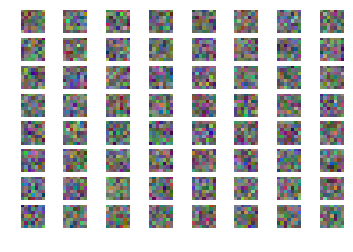

In [6]:
plot_first_kernels(model.feature[0].weight)
# plot_first_kernels(model.feature[0].weight)

[INFO]2019-11-01 15:41:48,937:main:Setting
[INFO]2019-11-01 15:41:48,939:main:Image size: (256, 256)
[INFO]2019-11-01 15:41:50,385:main:train size: 606829 valid size: 67427
[INFO]2019-11-01 15:41:50,391:main:train positive ratio: 0.143726 valid positive ratio: 0.146603
[INFO]2019-11-01 15:41:50,495:main:num of selected_images: 200000
[INFO]2019-11-01 15:41:50,500:main:Initializing classification model...


          Image  any  epidural  intraparenchymal  intraventricular  \
0  ID_000039fa0    0         0                 0                 0   
1  ID_00008ce3c    0         0                 0                 0   
2  ID_0000950d7    0         0                 0                 0   
3  ID_0000aee4b    0         0                 0                 0   
4  ID_0000f1657    0         0                 0                 0   

   subarachnoid  subdural   patient_id  
0             0         0  ID_eeaf99e7  
1             0         0  ID_ce8a3cd2  
2             0         0  ID_d278c67b  
3             0         0  ID_ce5f0b6c  
4             0         0  ID_df70c823  
          Image  any  epidural  intraparenchymal  intraventricular  \
0  ID_00005679d    0         0                 0                 0   
1  ID_0002081b6    1         0                 1                 0   
2  ID_00035b650    0         0                 0                 0   
3  ID_000447d36    0         0                 0     

[INFO]2019-11-01 15:41:51,398:main:start with pretrained model: ./models/data224/cbam_resnet50/101/best_model.pth


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


[INFO]2019-11-01 15:41:51,602:main:[Start] Training
[INFO]2019-11-01 15:41:51,603:main:[Start] epoch: 2
[INFO]2019-11-01 15:41:51,604:main:lr: 0.000050
[INFO]2019-11-01 15:41:51,664:main:num of selected_images: 200000
  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
[INFO]2019-11-01 15:41:58,019:main:
   count     mean       std        min       25%       50%       75%       max
0    6.0 -7.09375  2.001149 -10.210938 -8.266602 -6.482422 -5.720703 -5.058594
[INFO]2019-11-01 15:41:58,029:main:
   count     mean       std       min       25%       50%       75%       max
0    6.0  0.00226  0.002443  0.000037  0.000428  0.001556  0.003422  0.006314
[INFO]2019-11-01 15:41:58,030:main:train: 0 loss: 0.129395 (just now)
[INFO]2019-11-01 15:41:58,031:main:train: 0 loss: 0.129395

KeyboardInterrupt: 

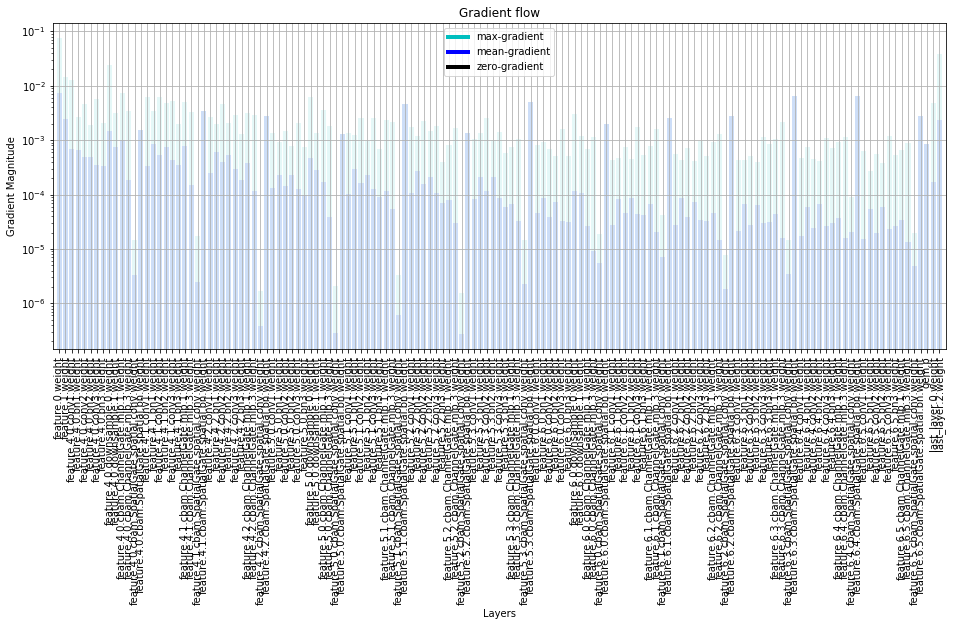

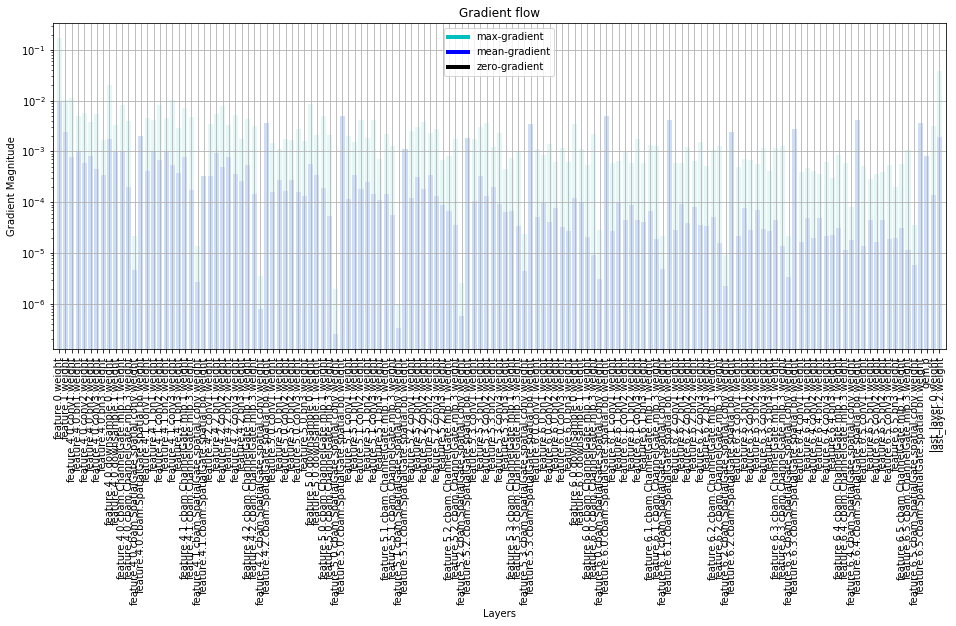

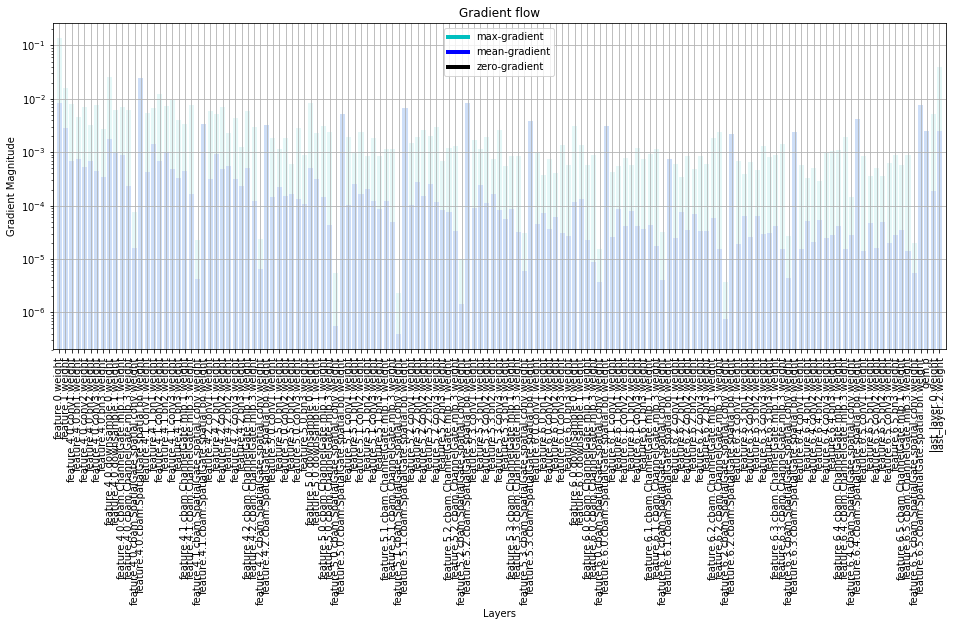

In [7]:
# predict()
train()